In [446]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [447]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
import scipy.io as sio

In [448]:
def EWT_Meyer_Scaling(w1, gamma, N):
    # Generate the 1D Meyer wavelet in the Fourier
    # domain associated to the segment [0, w1]
    # with transition ratio gamma

    Mi = int(np.floor(N/2))
    w = np.fft.fftshift(np.arange(0, 2*np.pi, 2*np.pi/N))
    w[:Mi] -= 2*np.pi

    aw = np.abs(w)
    yms = np.zeros(N)

    an = 1 / (2 * gamma * w1)
    pbn = (1 + gamma) * w1
    mbn = (1 - gamma) * w1

    for k in range(N):
        if aw[k] <= mbn:
            yms[k] = 1
        elif mbn <= aw[k] <= pbn:
            yms[k] = np.cos(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)

    yms = np.fft.ifftshift(yms)

    return yms

In [449]:
def EWT_beta(x):
    if x < 0:
        bm = 0
    elif x > 1:
        bm = 1
    else:
        bm = x**4 * (35 - 84 * x + 70 * x**2 - 20 * x**3)
    return bm

In [450]:
def EWT_Meyer_Wavelet(wn, wm, gamma, N):
    # Generate the 1D Meyer wavelet in the Fourier
    # domain associated to scale segment [wn, wm]
    # with transition ratio gamma

    Mi = int(np.floor(N/2))
    w = np.fft.fftshift(np.arange(0, 2*np.pi, 2*np.pi/N))
    w[:Mi] -= 2*np.pi

    aw = np.abs(w)
    ymw = np.zeros(N)

    an = 1 / (2 * gamma * wn)
    am = 1 / (2 * gamma * wm)
    pbn = (1 + gamma) * wn
    mbn = (1 - gamma) * wn
    pbm = (1 + gamma) * wm
    mbm = (1 - gamma) * wm

    for k in range(N):
        if pbn <= aw[k] <= mbm:
            ymw[k] = 1
        elif mbm <= aw[k] <= pbm:
            ymw[k] = np.cos(np.pi * EWT_beta(am * (aw[k] - mbm)) / 2)
        elif mbn <= aw[k] <= pbn:
            ymw[k] = np.sin(np.pi * EWT_beta(an * (aw[k] - mbn)) / 2)

    ymw = np.fft.ifftshift(ymw)

    return ymw

In [451]:
def EWT_Meyer_FilterBank(boundaries, N):
    # Generate the filter bank (scaling function + wavelets)
    # corresponding to the provided set of frequency segments

    Npic = len(boundaries)

    # Compute gamma accordingly to the theory
    gamma = 1
    for k in range(Npic - 1):
        r = (boundaries[k + 1] - boundaries[k]) / (boundaries[k + 1] + boundaries[k])
        if r < gamma:
            gamma = r

    r = (np.pi - boundaries[Npic - 1]) / (np.pi + boundaries[Npic - 1])
    if r < gamma:
        gamma = r
    gamma = (1 - 1 / N) * gamma  # This ensures that gamma is chosen as strictly less than the min

    mfb = [None] * (Npic + 1)

    # Start by generating the scaling function
    mfb[0] = EWT_Meyer_Scaling(boundaries[0], gamma, N)

    # Generate the wavelets
    for k in range(Npic - 1):
        mfb[k + 1] = EWT_Meyer_Wavelet(boundaries[k], boundaries[k + 1], gamma, N)

    mfb[Npic] = EWT_Meyer_Wavelet(boundaries[Npic - 1], np.pi, gamma, N)

    return mfb

In [452]:
mat_data = sio.loadmat('/content/drive/MyDrive/signalfile/sig.mat')
zf = mat_data['sig']
Fs = 500

In [453]:
zf.shape

(2500, 60)

In [454]:
zf1=zf.transpose()

In [455]:
x=zf1

In [456]:
# Signal normalization
for i in range(x.shape[0]):
    x[i, :] = x[i, :] / np.max(np.abs(x[i, :]))

# Projection of the multichannel data into the direction cosine
Combined = np.sum(x, axis=0) / np.sqrt(x.shape[0])
nfft = Fs

# Multivariate projection EWT
Z = np.abs(np.fft.fftshift(np.fft.fft(Combined, nfft)))
Z1 = Z[int(Fs / 2) + 1:]  # FFT domain signal

In [457]:
Z1=Z1.transpose()

In [458]:
Z1.shape

(249,)

In [459]:
import matplotlib.pyplot as plt


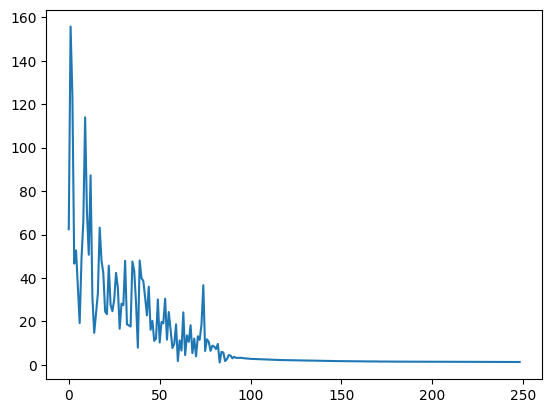

In [460]:
plt.plot(Z1)

In [461]:
def local_maxima(p):
    """
    Finds the local maxima of a 1D array and returns their indices.

    Parameters:
        x (numpy.ndarray): The input array

    Returns:
        maxima_indices (numpy.ndarray): Indices of the local maxima
    """

    maxima_indices = []
    for i in range(1, len(p) - 1):
        if (p[i - 1] < p[i]) and (p[i] > p[i + 1]):
            maxima_indices.append(i)

    return np.array(maxima_indices)

In [462]:
def sorted_local_maxima(q):
    # Find the local maxima indices
    maxima_indices = local_maxima(q)

    # Extract the corresponding values
    maxima_values = q[maxima_indices]

    # Sort the values and indices together
    sorted_maxima = sorted(zip(maxima_values, maxima_indices), reverse=True)

    # Extract the sorted maxima values and indices
    sorted_maxima_values, sorted_maxima_indices = zip(*sorted_maxima)

    return sorted_maxima_values, sorted_maxima_indices

In [463]:
# Get sorted local maxima and indices
sorted_maxima_values, sorted_maxima_indices = sorted_local_maxima(Z1)

print("Sorted local maxima values:", sorted_maxima_values)
print("Sorted local maxima indices:", sorted_maxima_indices)

Sorted local maxima values: (155.77569979221667, 113.96933601699907, 87.2363522430876, 63.13871635707226, 52.67693436513642, 48.030520609371386, 47.873825950078256, 47.55427412983756, 45.65404053908347, 42.33988709851149, 36.66208797086277, 35.95774713855621, 30.46309821290202, 30.130587209174475, 28.146946483003383, 24.314613695795682, 24.169175146796427, 20.26072621677526, 19.70311244359497, 18.675761187443715, 18.23499306710313, 13.551153370790628, 13.164090599332607, 12.102686311578646, 11.760050835329542, 11.254134117727071, 9.628777113830834, 8.869785763530176, 5.9575776100786895, 4.513690916570428, 3.709300107868662, 3.226230509231398, 1.6938400929977555, 1.6626636838559774, 1.6433733613965182, 1.6053175931966073, 1.57344341848465, 1.5641152454440004, 1.5425924517147611, 1.5207691109476675, 1.5077700830541498, 1.489960821313701, 1.4726348777657934, 1.4559384821375851, 1.4262504317772526, 1.4163292761854165, 1.4053115888225316, 1.3923766651997815, 1.37557763288267, 1.374546480341

In [464]:
N=20 #number of local maxima for the design of EWT filter bank

In [465]:
if len(sorted_maxima_indices) > N:
        sorted_indices = sorted_maxima_indices[:N]
else:
        sorted_indices = sorted_maxima_indices
        N = len(sorted_maxima_indices)

In [466]:
sorted_indices=np.sort(sorted_indices)

In [467]:
sorted_indices

array([ 1,  4,  9, 12, 17, 22, 26, 29, 31, 35, 39, 44, 46, 49, 51, 53, 55,
       59, 63, 74])

In [468]:
# Calculate middle points between consecutive maxima
bound = np.zeros(N)
for i in range(N):
   if i == 0:
      a = 1
   else:
       a = sorted_indices[i - 1]
       bound[i] = (a + sorted_indices[i]) // 2

In [469]:
bound

array([ 0.,  2.,  6., 10., 14., 19., 24., 27., 30., 33., 37., 41., 45.,
       47., 50., 52., 54., 57., 61., 68.])

<ipython-input-448-8a087b1dd2c1>:13: RuntimeWarning: divide by zero encountered in double_scalars
  an = 1 / (2 * gamma * w1)


Text(0.5, 1.0, 'MPEWT filter bank')

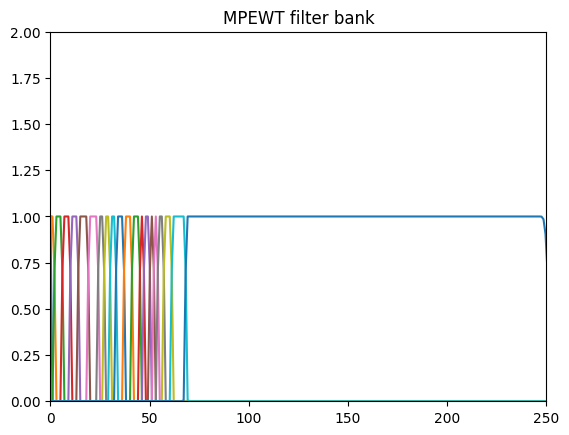

In [470]:
f=Z1
boundaries = (bound * (2 * np.pi)) / Fs  # Boundary evaluation from frequency
ff = np.fft.fft(f,nfft)

# Build the corresponding filter bank
mfb = EWT_Meyer_FilterBank(boundaries, len(ff))

# Filter the signal to extract each subband
ewt = [np.real(np.fft.ifft(np.conj(mfbk) * ff)) for mfbk in mfb]

# Plot the filter bank
plt.figure()
Bound = 1
xxx = np.linspace(0, 1, len(mfb[0])) * Fs
for i in range(len(mfb)):
    plt.plot(xxx, mfb[i])
plt.xlim([0, round(Fs/2)])
plt.ylim([0, 2])
plt.title('MPEWT filter bank')

In [471]:
x.shape

(60, 2500)

In [472]:
zz=x[1,:]

In [473]:
zz.shape

(2500,)

In [474]:
def mode_eval_each_channel(zz, mfb, Fs):
    """
    Evaluates the mode of each EWT subband.

    Parameters:
        zz (numpy.ndarray): Input signal
        mfb (list): List of EWT filters

    Returns:
        modes (numpy.ndarray): Array of modes for each EWT subband
    """

    ff=np.fft.fft(zz, Fs)
# Filter the signal to extract each subband
    modes = [np.real(np.fft.ifft(np.conj(mfbk) * ff)) for mfbk in mfb]

    return modes

In [475]:
ch=10 ####10th channel all modes
zz=x[1,:]
modesch1 = mode_eval_each_channel(zz, mfb, Fs)


<ipython-input-476-1185635776d0>:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


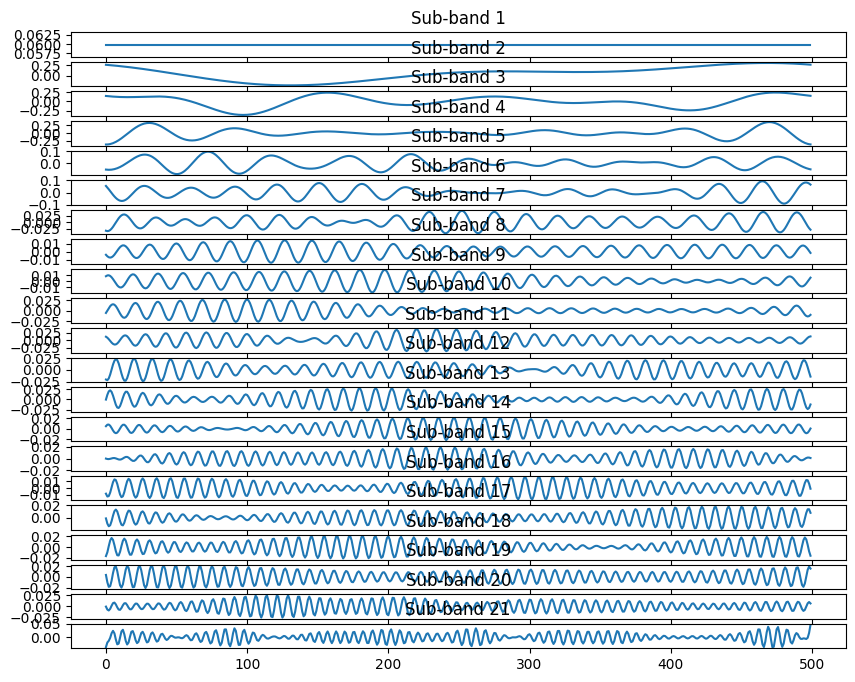

In [476]:
# Plot the sub-bands
plt.figure(figsize=(10, 8))
for i in range(N + 1):
    plt.subplot(N + 1, 1, i + 1)
    plt.plot(modesch1[i])
    plt.title(f'Sub-band {i + 1}')
    plt.tight_layout()